In [34]:
!pip install lifetimes

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data

In [9]:
import pandas as pd
df = pd.read_csv('/content/data.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12-01-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,12-01-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12-01-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12-01-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12-01-2010 08:26,3.39,17850.0,United Kingdom


In [12]:
df.dropna(inplace=True)
df = df[df['Quantity'] > 0]
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [13]:
df = df[df['Country'] == 'United Kingdom']

In [19]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='mixed', dayfirst=False, errors='coerce')
snapshot_date = df['InvoiceDate'].max() + pd.DateOffset(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalPrice': 'sum'
}).reset_index()
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

In [25]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(rfm['Frequency'], rfm['Monetary'])

<lifetimes.GammaGammaFitter: fitted with 2956 subjects, p: 3.41, q: 0.27, v: 3.39>

In [28]:
snapshot_date = df['InvoiceDate'].max() + pd.DateOffset(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

In [29]:
# Remove negative or zero monetary values if any
rfm = rfm[(rfm['Monetary'] > 0) & (rfm['Frequency'] > 0)]

In [35]:
# Create summary for BG/NBD
summary = summary_data_from_transaction_data(df, 'CustomerID', 'InvoiceDate', monetary_value_col='TotalPrice')

# Remove zero or negative monetary values
summary = summary[summary['monetary_value'] > 0]

# Filter invalid rows where recency > T
summary = summary[summary['recency'] <= summary['T']]

# Fit Model with Penalizer
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

# Predict expected purchases next 30 days
summary['predicted_purchases_30_days'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    30, summary['frequency'], summary['recency'], summary['T']
)

In [36]:
# Fit GammaGamma Model for CLV
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(summary['frequency'], summary['monetary_value'])

# Calculate CLV (3 months future, 1% monthly discount rate)
summary['CLV'] = ggf.customer_lifetime_value(
    bgf, summary['frequency'], summary['recency'], summary['T'], summary['monetary_value'],
    time=3, discount_rate=0.01
)

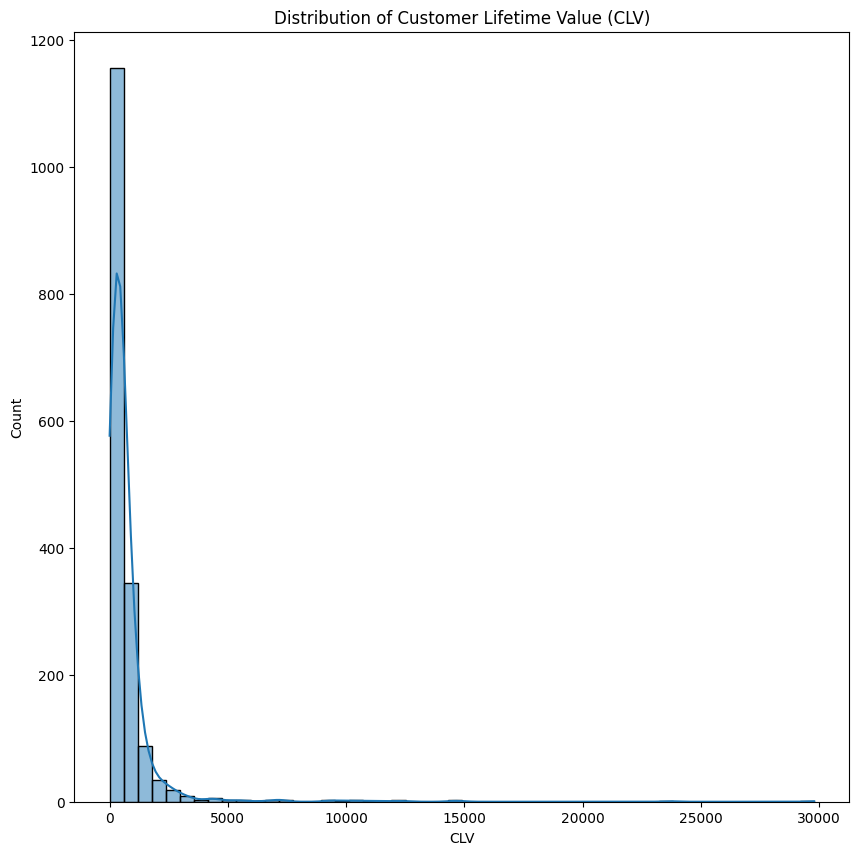

In [39]:
# Plot
plt.figure(figsize=(10, 10))
sns.histplot(summary['CLV'], bins=50, kde=True)
plt.title('Distribution of Customer Lifetime Value (CLV)')
plt.xlabel('CLV')
plt.show()

In [40]:
# Display Top Customers
summary.sort_values(by='CLV', ascending=False).head(10)

,frequency,recency,T,monetary_value,predicted_purchases_30_days,CLV
CustomerID,,,,,,
18102.0,14.0,241.0,260.0,7472.632857,1.340062,29783.357292
17450.0,15.0,259.0,260.0,5582.766667,1.427377,23681.408839
17511.0,18.0,259.0,266.0,3019.429444,1.654358,14816.815765
15749.0,1.0,97.0,225.0,21535.900000,0.189709,14502.416340
16029.0,28.0,259.0,266.0,1696.693571,2.492289,12500.142788
17949.0,16.0,257.0,264.0,2702.475000,1.495101,11999.436262
15311.0,61.0,261.0,266.0,732.480164,5.257884,11346.839178
12931.0,6.0,237.0,250.0,5356.483333,0.678336,10989.416234
16684.0,9.0,225.0,251.0,3682.693333,0.937493,10340.353807
